# Sentiment Analysis from text 
**Group:** HDer  
**Group Members:**  
Shu Wang (z5211077) (Group Leader)  
Wanxiao Huang (z5222629)   
Wanting Zhou (z5347036)  
Kanghong Yu (z5413510)  
Yinglu  Yang (z5390317)  


# Introduction and Data Source
### Introduction and Motivation
Sentiment analysis from text is done in order to identify subjective information in it and understand the opinions, feelings, and sentiments emanating from the text. (definition from https://www.repustate.com/blog/text-sentiment-analysis/)  
Sentiment analysis is very necessary. It can allow companies to understand the voice of users, improve products in time, and even guide product development to help companies develop better.  
### Problem Statement and Data Source of our Project
In our project, we do sentiment analysis from Amazon Reviews. You could find the data here: https://www.kaggle.com/datasets/bittlingmayer/amazonreviews    
The dataset contains a training set and a testing set, each is in bz2 format. The training set contains 3,600,000 records, and the testing set contains 400,000 records.  
Each records in both datasets consists of a label and a review.  
The label is either `__label__1` or `__label__2`. A review after `__label__1` is a 1- or 2-star review, which is a negative review. A review after `__label__2` is a 4- or 5-star review, which is a positive review. There are no neutral reviews (i.e. 3-star reviews) in this dataset.  
### Purpose of our Project
Our project aims to learn reviews and labels in the training set of Amazon Reviews dataset, and then predict labels of unseen reviews in the testing set; this turns our problem to a binary classification problem. From sentiment analysis view, our project aims to learn sentiments of reviews in the training set, and analyze sentiments of unseen reviews in testing set.

In [80]:
import numpy as np
import pandas as pd
import re
import torch
from time import time
import bz2 # to decompress the dataset
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings # ignore warnings
warnings.filterwarnings('ignore')
from gensim.models import Word2Vec 
from gensim.models import KeyedVectors
import multiprocessing
from collections import Counter, OrderedDict
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [83]:
print('Version of Pytorch: ' + str(torch.__version__))

Version of Pytorch: 1.11.0+cu113


In [2]:
# define paths
train_path = "input/train.ft.txt.bz2"
test_path = "input/test.ft.txt.bz2"
word2vec_path = "word2vec.wordvectors"
word2vec_npy_path = "word2vec.wordvectors.vectors.npy"
index2word_path = "index2word.npy"
word2index_path = "word2index.npy"
index2vec_path = "index2vec.npy"
train_ids_npy_path = "train_ids.npy"
test_ids_npy_path = "test_ids.npy"
train_label_npy_path = "train_labels.npy"
test_label_npy_path = "test_labels.npy"

# Exploratory Data Analysis (Pre-Processing)  
In this part, we will give several examples of records in both classes (`__label__1` and `__label__2`).  
Then I will **Clean Reviews** because there are words that are meaningless to sentiment analysis, like numbers, urls, and typos. There are also special characters, like punctuation that need to be delete.  
Then we will build a **Word2Vec** using cleaned reviews in the training set. 

## Read data
If you want to run this code, please download the bz2 files from https://www.kaggle.com/datasets/bittlingmayer/amazonreviews , and put them into the directory of this notebook.

In [5]:
def decompress(file):
    '''
        Function to decompress the bz2 file 
        and return list of lines
    '''
    lines = []
    for line in bz2.BZ2File(file):
        x = line.decode("utf-8")
        lines.append(x)
    return lines

In [4]:
# get lines of train and test
train_lines = decompress(train_path)
test_lines = decompress(test_path)

### Examples of Reviews in each Class
Then show several lines of both sets to see how the data looks like.

In [29]:
print('The first 5 lines of training set:')
for i in range(5):
    print(train_lines[i])
print('\nThe first 5 lines of testing set:')
for i in range(5):
    print(test_lines[i])

The first 5 lines of training set:
__label__2 Stuning even for the non-gamer: This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^

__label__2 The best soundtrack ever to anything.: I'm reading a lot of reviews saying that this is the best 'game soundtrack' and I figured that I'd write a review to disagree a bit. This in my opinino is Yasunori Mitsuda's ultimate masterpiece. The music is timeless and I'm been listening to it for years now and its beauty simply refuses to fade.The price tag on this is pretty staggering I must say, but if you are going to buy any cd for this much money, this is the only one that I feel would be worth every penny.

__la

In [6]:
#len(train_lines)

3600000

In [7]:
#train_lines[0]

'__label__2 Stuning even for the non-gamer: This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^\n'

## Change labels
Since labels are in format `__label__1` and `__label__2`, which is not easy to use when doing classification. Therefore, we change `__label__1` to 0 to represent negative class, and chaneg `__label__2` to 1 to represent positive class. Then the classification could be easily done by making output between 0 and 1, which is the probability of this review belongs to the positive class.

In [8]:
# change the label to number 
# 0 for label 1 and 1 for label 2
# substitude labels
train_new_label_lines = [re.sub('__label__1', '0', x) for x in train_lines]
train_new_label_lines = [re.sub('__label__2', '1', x) for x in train_new_label_lines]

test_new_label_lines = [re.sub('__label__1', '0', x) for x in test_lines]
test_new_label_lines = [re.sub('__label__2', '1', x) for x in test_new_label_lines]

In [9]:
# get labels
label_train = [x.split(' ')[0] for x in train_new_label_lines]
label_test = [x.split(' ')[0] for x in test_new_label_lines]

# get sentence
train_sentence = [x[2:].lower() for x in train_new_label_lines]
test_sentence = [x[2:].lower() for x in test_new_label_lines]

In [10]:
# I want check if the data has balanced classes
if label_train.count('0') == label_train.count('1'):
    print('Training set has balanced classes, each class has ' + str(label_train.count('0')) + ' reviews.')
else:
    print('Training set has imbalanced classes, positive has ' + str(label_train.count('1')) 
          + ' reviews, and negative class has ' + str(str(label_train.count('1'))) + ' reviews.')

if label_test.count('0') == label_test.count('1'):
    print('Testing set has balanced classes, each class has ' + str(label_test.count('0')) + ' reviews.')
else:
    print('Testning set has imbalanced classes, positive has ' + str(label_test.count('1')) 
          + ' reviews, and negative class has ' + str(str(label_test.count('1'))) + ' reviews.')

Training set has balanced classes, each class has 1800000 reviews.
Testing set has balanced classes, each class has 200000 reviews.


We get half of both training set and testing set because the original datasets are too large.

In [12]:
# set the random state so we could get same samples
_, sample_x_train, _, sample_y_train = train_test_split(train_sentence, label_train, test_size=0.5, random_state=9)
_, sample_x_test, _, sample_y_test = train_test_split(test_sentence, label_test, test_size=0.5, random_state=9)

In [13]:
# I want check if the sample data has balanced classes
if sample_y_train.count('0') == sample_y_train.count('1'):
    print('Training set has balanced classes, each class has ' + str(sample_y_train.count('0')) + ' reviews.')
else:
    print('Training set has imbalanced classes, positive has ' + str(sample_y_train.count('1')) 
          + ' reviews, and negative class has ' + str(str(sample_y_train.count('0'))) + ' reviews.')

if sample_y_test.count('0') == sample_y_test.count('1'):
    print('Testing set has balanced classes, each class has ' + str(sample_y_test.count('0')) + ' reviews.')
else:
    print('Testing set has imbalanced classes, positive has ' + str(sample_y_test.count('1')) 
          + ' reviews, and negative class has ' + str(str(sample_y_test.count('0'))) + ' reviews.')

Training set has imbalanced classes, positive has 900945 reviews, and negative class has 899055 reviews.
Testing set has imbalanced classes, positive has 99902 reviews, and negative class has 100098 reviews.


As we could see, it is not really balance, but I think it is ok.

## Remove special characters
1. remove \n in the end if each sentence. We could delete it because it is just the line break and each line has it, so it is meaningless to the sentiment analysis.    
2. use \<num\> for all numbers. My function covered formats like: '99', '99.00', '$99', '99,000'. We could delete numbers because the same number could have both positive and negative sentiment. For example, 12 could be in 'I recommend this to 12 friends', then it is a positive review, or it could be in 'it wasted 12 hours of my life', then it is negative. Numbers will also increase the number of total words in the vocabulary of the word vector model, so we just use \<num\> to replace them to keep the integrality of reviews.    
3.use \<url\> for all website addresses. We do this also because urls are meaningless and will increase the size of the vocabulary.  
4. remove all expect a-z0-9 and \<\> to remove punctuations and other special characters (because we have \<num\> for numbers, \<unk\> for words with low frequency, and \<pad\> for padding).  

In [14]:
def remove_special_char(l):
    '''
        Remove special characters from list of sentences
    '''
    
    no_special_char = re.compile('[^a-z0-9\<\>\s+]')
    # I find this pattern from https://blog.csdn.net/u012995500/article/details/106791568
    url_pattern = r"[http://|ftp://|https://|www]?[^\u4e00-\u9fa5\s]*?\.[com|net|cn|me|tw|fr][^\u4e00-\u9fa5\s]*"
    
    # first make a copy of l, because I do not want to change the original list
    clean_l = [x for x in l]
    for i in range(len(clean_l)):
        clean_l[i] = re.sub('\n', '', clean_l[i]) # delete \n in the end of each sentence 
        clean_l[i] = re.sub(r'\d+[\.]*[\d+]*[\,\d+]*[\'s]*', ' <num> ', clean_l[i]) # use <num> to replace all numbers
        if ('http:' in clean_l[i] or 'ftp:' in clean_l[i] or 'https:' in clean_l[i] or 'www.' in clean_l[i] 
        or '.com' in clean_l[i] or '.net' in clean_l[i] or '.cn' in clean_l[i] or '.me' in clean_l[i] or '.tw' in clean_l[i] or '.fr' in clean_l[i]):
            clean_l[i] = re.sub(url_pattern, '<url>', clean_l[i]) # use <url> for all websites
        clean_l[i] = re.sub(no_special_char, ' ', clean_l[i].lower()) # only keep a-z0-9 and <> for <num> and <url>
        
        # when I first tried the pre-processing, I found there are two words that are not seperated, like 'goodthe'
        # I think this happens because sometimes there are no space after comma or fullstop
        # so now I use a space to replace special characters, but this will cause more than one consecutive spaces
        # when split by space, there will be empty words
        # so I use one space to substitude 1 to n spaces, and then use strip to delete space at the begining and end or sentence
        clean_l[i] = re.sub(r"\s+", " ", clean_l[i]) 
        clean_l[i] = clean_l[i].strip()
                
    return clean_l

# do this for both datasets
clean_x_train = remove_special_char(sample_x_train)
clean_x_test = remove_special_char(sample_x_test)

Since there are empty lines, if we split it directly, there will be errors, so fill the empty line with \<unk\>

In [17]:
for i in range(len(clean_x_train)):
    if clean_x_train[i] == '':
        clean_x_train[i] = '<unk>'
for i in range(len(clean_x_test)):
    if clean_x_test[i] == '':
        clean_x_test[i] = '<unk>'

### Compare the cleaned and uncleaned reviews
Use severial lines to see the result of cleaning.

In [32]:
print('Before cleaning:')
print(sample_x_train[15])
print('After cleaning:')
print(clean_x_train[15])

Before cleaning:
was this the album that was supposd to be sooo great?: well , i think it sucks. it is uninspired garbage. hopefully this album is the end of dmx's career. none of his albums have been any good. he might have made 3 or 4 good songs in his whole career. this album has so many different sounds that it's too hard to get into. it sounds like " let's try this ", and that technique usually fails.

After cleaning:
was this the album that was supposd to be sooo great well i think it sucks it is uninspired garbage hopefully this album is the end of dmx s career none of his albums have been any good he might have made <num> or <num> good songs in his whole career this album has so many different sounds that it s too hard to get into it sounds like let s try this and that technique usually fails


In [36]:
print('Before cleaning:')
print(sample_x_train[1676189])
print('After cleaning:')
print(clean_x_train[1676189])

Before cleaning:
........: ............ ..... ..... ...... ...... ....... ..... ....... ....... ........ ......... ........ ........ ..... ......... ..... ..... ...... .. ......

After cleaning:
<unk>


Then split each review to a list of words because we need words to build word vectors.

In [18]:
# I do not know why there is error 'float type do not have split'
# => I found the reason, this is because there is NaN in the review column
x_train_list = [x.split(' ') for x in clean_x_train]
x_test_list = [x.split(' ') for x in clean_x_test]

## Build word vector from training data using gensim
### What is Word2Vec and why use it
Since computer could only read numerical values, so we need to change words into numerical values. There are many ways to do this, like one-hot encoding and bag of words. We choose to use word vectors, because word vectors not only change words into numerial vectors, but also make words with similar sentiments closer to each other in the word vector space. This will be very helpful to our sentiment analysis.  
# How to build Word2Vec using own data
The idea to build word vectors is that words with similar contexts have similar sentiment.  
There are 2 popular methods to build word vectors, the first is **CBOW** (continuous bag of words), which use given contexts to predict the word in the center, and the other is **Skip-gram**, which use the given center word to predict contexts. In this project, word vectors are built by feeding training reviews to the Skip-gram model using the Word2Vec in the genism module.   
When training **Skip-gram**, we feed two words to the Skip-gram model and tell it they are neighbours. When testing the model, we also feed two words to it and ask it: what is the probability that they are neighbours. Therefore, we need negative sampling or the model will always answer one. Which means, we training the model, we need pairs of words that are neighbours, and we also need to make pairs of words that could not be neighbours, and feed them to the model.  

I use following tutorials when building word vectors myself:  
https://radimrehurek.com/gensim/models/word2vec.html (functions)  
https://www.kaggle.com/code/pierremegret/gensim-word2vec-tutorial/notebook (train model)  
https://radimrehurek.com/gensim/models/keyedvectors.html (store trained vector)  

In [20]:
'''
    parameters:
    min_count: int, the word vector will not include words with frequency < min_count
                so I set this to 2 to delete words that appears only once
    window: int, number of neighbours [window target window]
            I want to choose 3.
    size: int, dimensionality of the vector, I think 100 is enough
    sample: float, frequency of downsampling
    alpha: float, initial learning rate
    min_alpha: float, the min learning rate in the training process
    negative: int, number of negative sampling
    workers: int, faster if more users are used
'''
cores = multiprocessing.cpu_count()
model = Word2Vec(vector_size=100, 
                 window=3, 
                 min_count=2,
                 sample=6e-5,
                 alpha=0.03, min_alpha=0.0008,
                 negative=5, ns_exponent=0.75,
                 workers=cores-2)

**Build vocab**  
Build vocabulary from a sequence of sentences (can be a once-only generator stream).

In [23]:
t = time()

model.build_vocab(x_train_list,progress_per=50000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

Time to build vocab: 0.8 mins


**Train word vector**  
Update the model’s neural weights from a sequence of sentences.

In [25]:
t = time()

model.train(x_train_list, total_examples=model.corpus_count, epochs=100, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

Time to train the model: 67.06 mins


#### Save trained word vector
(we do this because training word vectors takes really a long time so we do not want to do this again)  
This will save a **word2vec.wordvectors** file and a **word2vec.wordvectors.vectors.npy** file.  
**word2vec.wordvectors** is in KeyedVector format, and **word2vec.wordvectors.vectors.npy** is an nd-array of vectors.

In [30]:
word2vec = model.wv
word2vec.save(word2vec_path)

Load vector:

In [38]:
# Load back with memory-mapping = read-only, shared across processes.
word2vec = KeyedVectors.load(word2vec_path, mmap='r')

# get index to words
index2word = list(word2vec.index_to_key)
# get words to index
word2index = word2vec.key_to_index
# .npy file version
index2vec = np.load(word2vec_npy_path)

This is the length of word vectors. It means that there are 247239 words appeared more than once in the training set.

In [39]:
len(index2vec)

247239

Now we could use **word2index** to find index for each word, and use **index2vec** to find the vector for each word.  
But we need to add **\<pad\>** and **\<unk\>** to each list.   
I read several posts about this and decide to use all 0's for \<pad\> and average vector for \<unk\>.  

Use average vector for \<unk\>:   
https://stackoverflow.com/questions/49239941/what-is-unk-in-the-pretrained-glove-vector-files-e-g-glove-6b-50d-txt

In [40]:
# get vectors
# <unk>:
average_vec = np.mean(index2vec, axis=0)
#print(average_vec)
# <pad>:
zero_vec = np.zeros(100, dtype=float)
#print(zero_vec)

# add to index2word
index2word = index2word + ['<unk>', '<pad>']

# add to word2index
pad_and_unk = {
    '<pad>':247240,
    '<unk>':247239
}
word2index.update(pad_and_unk)

# add to index to vector
index2vec = np.append(index2vec, [average_vec, zero_vec], axis=0)

Now I want to store the new version to .npy file.

In [44]:
np.save(index2word_path, index2word)
np.save(word2index_path, word2index)
np.save(index2vec_path, index2vec)
del index2word, word2index, index2vec

Then try to load them

In [45]:
index2word = np.load(index2word_path, allow_pickle=True)
word2index = np.load(word2index_path, allow_pickle=True).item()
index2vec = np.load(index2vec_path, allow_pickle=True)

In [46]:
# this is padding
index2vec[247240]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

Try my word vector.  
The model tells us words that are most similar to **nice** are 'neat', 'great', 'perfect', ...  
Words that are most similar to **bad** are 'terrible', 'horrible', 'awful', ...  
Therefore, my **Word2Vec** works well.

In [49]:
word2vec.most_similar(positive=["nice"])

[('neat', 0.7733117341995239),
 ('great', 0.7211542129516602),
 ('perfect', 0.7036304473876953),
 ('nifty', 0.6931633949279785),
 ('good', 0.6893448233604431),
 ('stylish', 0.6752407550811768),
 ('compact', 0.6616999506950378),
 ('attractive', 0.6606835126876831),
 ('cool', 0.6499606370925903),
 ('solid', 0.6488802433013916)]

In [50]:
word2vec.most_similar(positive=["bad"])

[('horrible', 0.8299480080604553),
 ('terrible', 0.8204277157783508),
 ('awful', 0.7719299793243408),
 ('lousy', 0.7351741194725037),
 ('crappy', 0.7268240451812744),
 ('horrid', 0.7229216694831848),
 ('lame', 0.7025347352027893),
 ('aweful', 0.6950370669364929),
 ('stupid', 0.6816142797470093),
 ('sucky', 0.6804616451263428)]

## Padding Reviews
Since we need a fixed size of inputs to sentiment analysis models, and the input to models are batches of reviews, and each word in the review is a word vector, so we need to pad all reviews to the same length.

In [51]:
# first get max lenght of sentence
max_len = max(len(x) for x in x_train_list)
max_len

258

In [52]:
sentence_len = []
for i in x_train_list:
    sentence_len.append(len(i))

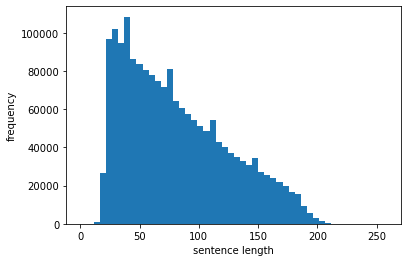

In [53]:
plt.hist(sentence_len, 50)
plt.xlabel('sentence length')
plt.ylabel('frequency')
plt.show()

In [58]:
# check percentage of reviews that is shorted than or equal to 200 words
counter = 0
for i in sentence_len:
    if i <= 200:
        counter += 1
p = float(counter)/float(len(sentence_len))
print('There are ' + str(round((p*100), 2)) + '% of reviews have length shorter than or equal to 200 words.')

There are 99.86% of reviews have length shorter than or equal to 200 words.


Since there are 99.86% of reviews have length shorter than or equal to 200 words, so I think 200 is a reasonable padding length. 

### Padding and replace words not in Word2Vec using \<unk\>
Since there are many words appeared only once in the training set, and there might be words in the testing set that did not appear in the training set, so we need to use some word to replace them, or it will make errors when we use word vectors. We choose **\<unk\>** to represent **unknown word**.  
In this part, we will change reviews from list of words into list of indices, so that when we work on models, we could use list of indices to get list of vectors for each review.

In [59]:
# define a function for it
def padding_and_unk(sentence_list, pad_len, word2index):
    '''
        sentence_list: a list of lists of words
        max_len: length for padding
        word2index: the dictionary of word, index key-value pairs
    '''
    # empty list
    padded_list = []
    pad_id = word2index['<pad>']
    unk_id = word2index['<unk>']
    for sentence in sentence_list:
        
        if len(sentence) >= pad_len:
            # if sentence is longer than pad_len
            # we only use the first pad_len words
            temp_list = sentence[:pad_len]
        else:
            # if sentence is shorter than pad_len
            # pad the sentence to pad_len
            temp_list = np.zeros((pad_len), dtype='int32')
            temp_list.fill(pad_id) # <pad>
            
        # if sentence is shorter than padded length, then we use the sentence length (we only want to check words)
        # if the sentence is longer than padded length, we want to pad_len words
        if len(sentence) < pad_len:
            check_len = len(sentence)
        else:
            check_len = pad_len
        
        # now check each word
        for i in range(check_len):
            try:
                # if could find in dict, then store the index
                temp_list[i] = word2index[sentence[i]]
            except KeyError:
                # if not, store the index for <unk>
                temp_list[i] = unk_id # <unk>
        padded_list.append(list(temp_list))
        
    return padded_list

In [60]:
# padding and replacing to the training and testing set
t = time()
# use function to padding my lists
pad_len = 200
x_padded_train_list = padding_and_unk(x_train_list, pad_len, word2index)
x_padded_test_list = padding_and_unk(x_test_list, pad_len, word2index)

print('Time to padding and replace: {} mins'.format(round((time() - t) / 60, 2)))

Time to padding and replace: 18.27 mins


### Now store this to .npy file together with labels 
It takes a lot of time, so I do not want to do it again

In [63]:
# save ids
t = time()
np.save(train_ids_npy_path, x_padded_train_list)
np.save(test_ids_npy_path, x_padded_test_list)
print('Time to save ids: {} mins'.format(round((time() - t) / 60, 2)))

# save labels
t = time()
np.save(train_label_npy_path, sample_y_train)
np.save(test_label_npy_path, sample_y_test)
print('Time to save labels: {} mins'.format(round((time() - t) / 60, 2)))

Time to save ids: 2.04 mins
Time to save labels: 0.01 mins


# Models  
In the modeling part, we tried 3 different popular models in the NLP field and compare their performances.  
3 models we tried are **CNN**, **LSTM**, and **GRU**.

## Model 1: Convolutional Neural Network -- CNN
 
Traditionally, the CNN model is used for image processing and analysis, but recently, CNN has been used in the NLP field widely. As the image is 2-dimensional. Different from images, the text is 1-dimensional, so the first thing in building the model is to visualize the texts to 2-dimensional by converting the words into word embeddings.  

I implement the model with 1-dimensional convolution layers, where the embedding dimension is the depth of the filter and the number of tokens in the sentences is the width.   
**Convolutional Layers:**  
In this model, I implement the convolutional layers with Conv1D. The in_channels argument is the number of "channels" in the image (or word) going into the convolutional layer. Different from images, when using text, there is only a single channel, the text itself. The out_channels is the number of filters and the kernel_size is the size of the filters. Each of our kernel_sizes is going to be [n x emb_dim] where 𝑛 is the size of the n-grams. Then pass the tensors through the convolutional and pooling layers, using the ReLU activation function (σ(x)=max⁡\{ 0,x}) after the convolutional layers.  
**Pooling Layers:**
Another important layer is the pooling layer on the output of the convolutional layers. In this model, I choose to use max pooling instead of average pooling, which means, the previous layer is divided into small groups of units and the maximum activation among each small group of units is copied to a single unit in the subsequent layer.  
**Regularization layer (Dropout Layer):**  
The Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting. Inputs not set to 0 are scaled up by 1/(1-rate) such that the sum over all inputs is unchanged.
**Hyperparameter choosing:**  
Initially, I set epoch=10 to train the model, from the plot shows that after the 4th epoch, the valid accuracy is getting lower than the training accuracy while the training accuracy keeps increasing. If the number of epochs increases, this may result in overfitting, so I decrease the epochs to 4  

Reference: https://colab.research.google.com/github/bentrevett/pytorch-sentiment-analysis/blob/master/4%20-%20Convolutional%20Sentiment%20Analysis.ipynb#scrollTo=uBQe6ctumfyX

### Prepare data
Since my laptop might run out of memory, so I store files and load them when training models.

In [3]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [27]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from time import time
import torchtext
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset,TensorDataset
from torchtext import data,datasets
import torch.optim as optim
import seaborn as sns
from sklearn.metrics import f1_score, confusion_matrix, classification_report
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
index2word_path = "index2word.npy"
word2index_path = "word2index.npy"
index2vec_path = "index2vec.npy"
train_ids_npy_path = "train_ids.npy"
test_ids_npy_path = "test_ids.npy"
train_label_npy_path = "train_labels.npy"
test_label_npy_path = "test_labels.npy"

In [12]:
x_ids_train = np.load(train_ids_npy_path, allow_pickle=True)
x_ids_test = np.load(test_ids_npy_path, allow_pickle=True)
y_train = np.load(train_label_npy_path, allow_pickle=True)
y_test = np.load(test_label_npy_path, allow_pickle=True)
index2word = np.load(index2word_path, allow_pickle=True)
word2index = np.load(word2index_path, allow_pickle=True).item()
index2vec = np.load(index2vec_path, allow_pickle=True)
x_ids_train = x_ids_train.astype(int)
x_ids_test = x_ids_test.astype(int)
y_train = y_train.astype(int)
y_test = y_test.astype(int)

### Build the model
Use 1-dimensional convolutional layers, where the embedding dimension is the "depth" of the filter and the number of tokens in the sentence is the width.

In [9]:
class CNN1d(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, 
                 dropout, pad_idx):
        
        super().__init__()
        
        # embedding_dim=100, which means the dim of each word vector
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.convs = nn.ModuleList([
                                    nn.Conv1d(in_channels = embedding_dim, 
                                              out_channels = n_filters, 
                                              kernel_size = fs)
                                    for fs in filter_sizes
                                    ])
        
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        
        self.dropout = nn.Dropout(dropout)    # Avoid overfitting dropout=0.5
        
    def forward(self, text):
        
        #text = [batch size, sent len]
        
        embedded = self.embedding(text)
                
        #embedded = [batch size, sent len, emb dim]
       
        embedded = embedded.permute(0, 2, 1)
        
        #embedded = [batch size, emb dim, sent len]
        
        conved = [F.relu(conv(embedded)) for conv in self.convs]  # using ReLu activation
            
        #conved_n = [batch size, n_filters, sent len - filter_sizes[n] + 1]
        
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]  # using max pooling to find the 'most important' feature
        
        #pooled_n = [batch size, n_filters]
        
        cat = self.dropout(torch.cat(pooled, dim = 1))  # avoid overfitting, dropout=0.5
        
        #cat = [batch size, n_filters * len(filter_sizes)]
            
        return self.fc(cat)

In [13]:
batch_size = 512

test_data = TensorDataset(torch.from_numpy(x_ids_test).to(device), torch.from_numpy(y_test).to(device))

train_data = x_ids_train[:1700000]    # train_data size = 1700000
valid_data = x_ids_train[1700000:]
y_train_data = y_train[:1700000]    # validation_data size = 100000
y_valid_data = y_train[1700000:]

train_data = TensorDataset(torch.from_numpy(train_data).to(device), torch.from_numpy(y_train_data).to(device))
valid_data = TensorDataset(torch.from_numpy(valid_data).to(device), torch.from_numpy(y_valid_data).to(device))


train_iterator = torch.utils.data.DataLoader(train_data, 
                                             batch_size, 
                                             shuffle = True, 
                                             )
valid_iterator = torch.utils.data.DataLoader(valid_data, 
                                             batch_size, 
                                             shuffle = True, 
                                             )
test_iterator = torch.utils.data.DataLoader(test_data, 
                                            batch_size, 
                                            shuffle = False, 
                                            )

Set the parameters.

In [14]:
INPUT_DIM = len(word2index)
EMBEDDING_DIM = 100   # the dim of each word vector
N_FILTERS = 150   # total = 150 * 4 = 600
FILTER_SIZES = [2,3,4,5]  #  four different sizes of filters to cover 2, 3, 4, 5 sequential words
OUTPUT_DIM = 1  # only one output of the probability
DROPOUT = 0.5  # avoid overfitting
PAD_IDX = word2index['<pad>']

model = CNN1d(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)

Load the pre-trained embeddings.

In [15]:
embedding_matrix = torch.from_numpy(index2vec)
model.embedding.weight.data.copy_(embedding_matrix)

tensor([[ 9.6620e-01,  8.9641e-01,  8.9497e-01,  ...,  1.6644e-01,
         -1.1420e+00,  9.3822e-01],
        [-3.2080e-01, -4.1956e-01,  1.7682e+00,  ..., -3.9620e-01,
          2.5392e+00, -3.9942e-01],
        [ 3.4887e-01,  3.3238e-01,  4.1357e-01,  ...,  4.1964e-01,
          1.7218e-01, -1.7007e-01],
        ...,
        [-3.7148e-01,  2.3935e-01, -3.5567e-01,  ..., -1.8063e-01,
         -3.3152e-02, -3.7497e-01],
        [ 3.0105e-03,  2.8680e-02,  1.3764e-03,  ..., -1.5941e-01,
         -2.1332e-01,  1.1867e-01],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00]])

### Train the Model
Initialize the optimizer (Adam), loss function (BCEWithLogitsLoss) and place the model

In [17]:
# Define the loss function and optimize the method
optimizer = optim.Adam(model.parameters())
criterion = nn.BCEWithLogitsLoss()    # as this is a binary classification
#criterion = nn.CrossEntropyLoss()     cross entropy is less effective as BCE

model = model.to(device)
criterion = criterion.to(device)

Define a function for training the model.

In [18]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:    # batch = [text, label]

        text = batch[0]

        label = batch[1].float()

        optimizer.zero_grad() # The gradient calculation result of the previous batch is not required when the next batch gradient calculation is performed

        predictions = model(text).squeeze(1)

        round_pred = torch.round(torch.sigmoid(predictions))    # to make the output between 0 to 1
        
        loss = criterion(predictions, label)  # nn.BCEWithLogitsLoss() 

        correct = (round_pred == label).float()

        acc = correct.sum() / len(correct)  # Calculate accuracy, which will return accuracy every patch

        #print(f'\tTrain Loss: {loss:.3f} | Train Acc: {acc*100:.2f}%')
        
        loss.backward()   # loss derivative
        
        optimizer.step()  # Update parameters
        
        epoch_loss += loss.item()   # tensor.item() gets the value of tensor
        epoch_acc += acc.item()

        loss = epoch_loss / len(iterator) # calculate loss and accuracy
        acc = epoch_acc / len(iterator)
        
    return loss, acc

Define a function for testing the model.

In [19]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    predic = []

    with torch.no_grad(): # will not track the gradient
    
        for batch in iterator:

            text = batch[0]

            label = batch[1].float()

            predictions = model(text).squeeze(1)

            round_pred = torch.round(torch.sigmoid(predictions))

            predic.append(round_pred)
            
            loss = criterion(predictions, label)

            correct = (round_pred == label).float()

            acc = correct.sum() / len(correct)      

            epoch_loss += loss.item()
            epoch_acc += acc.item()

            loss = epoch_loss / len(iterator)
            acc = epoch_acc / len(iterator)
        
    return loss, acc, predic

Start training the model.

After training the model with different epochs, I set the number of epochs to 4 to avoid overfitting.

In [24]:
t = time()
N_EPOCHS = 4

best_valid_loss = float('inf')

trainloss = []
trainacc = []
vloss = []
vacc = []
epo = []

for epoch in range(N_EPOCHS):
    epo.append(epoch + 1)
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc, valid_label = evaluate(model, valid_iterator, criterion)
    # reocrd loss and accuracy in each epoch
    trainloss.append(train_loss)
    trainacc.append(train_acc)
    vloss.append(valid_loss)
    vacc.append(valid_acc)  
    torch.save(model.state_dict(), './CNN_good_model.pt')
 
    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

Epoch: 01
	Train Loss: 0.214 | Train Acc: 91.50%
	 Val. Loss: 0.175 |  Val. Acc: 93.33%
Epoch: 02
	Train Loss: 0.176 | Train Acc: 93.29%
	 Val. Loss: 0.162 |  Val. Acc: 93.90%
Epoch: 03
	Train Loss: 0.158 | Train Acc: 94.10%
	 Val. Loss: 0.161 |  Val. Acc: 93.97%
Epoch: 04
	Train Loss: 0.146 | Train Acc: 94.61%
	 Val. Loss: 0.159 |  Val. Acc: 94.19%
Time to train the model: 15.97 mins


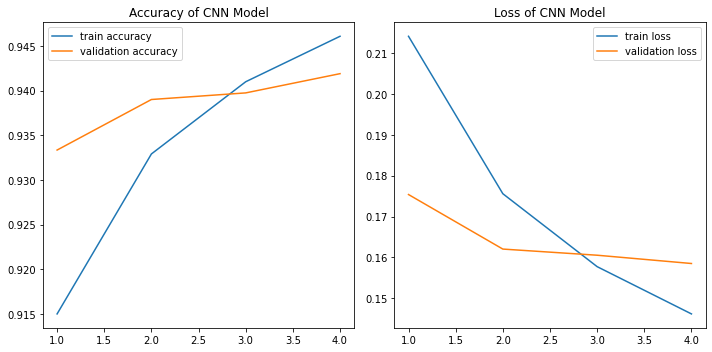

In [31]:
# plot accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epo,trainacc,label = "train accuracy")
plt.plot(epo,vacc,label = "validation accuracy")
plt.legend()
plt.title('Accuracy of CNN Model')

# plot loss
plt.subplot(1, 2, 2)
plt.plot(epo,trainloss,label = "train loss")
plt.plot(epo,vloss,label = "validation loss")
plt.legend()
plt.title('Loss of CNN Model')

plt.tight_layout()
plt.show()

### Test the Model
Run the model on test set and see its performance.

#### Test Accuracy

In [32]:
test_loss, test_acc, test_pred = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.159 | Test Acc: 94.15%


#### Confusion matrix

In [33]:
list1 = []
for i in test_pred:
  for j in i:
    list1.append(j)

In [35]:
ytest = torch.from_numpy(y_test).cpu()
list2 = torch.tensor(list1).cpu()
matrix = classification_report(ytest, list2,labels=[1,0], zero_division=0.0)
print('Classification matrix : \n',confusion_matrix(ytest, list2))
print('\nClassification report : \n',matrix)

Classification matrix : 
 [[95084  5014]
 [ 6676 93226]]

Classification report : 
               precision    recall  f1-score   support

           1       0.95      0.93      0.94     99902
           0       0.93      0.95      0.94    100098

    accuracy                           0.94    200000
   macro avg       0.94      0.94      0.94    200000
weighted avg       0.94      0.94      0.94    200000



### Heat Map

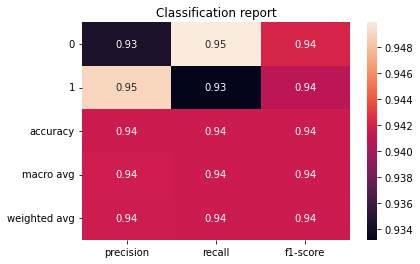

In [36]:
sns.heatmap(pd.DataFrame(classification_report(
         ytest, list2, zero_division=0.0,output_dict=True)).iloc[:-1, :].T, annot=True)
plt.title('Classification report')
plt.show()

### Best Model
Since we try this model more than once, the performance of each time is different even if we did not change parameters. We got   
**Test Loss: 0.158 | Test Acc: 94.19%**   
in previous training.

## Model 2: Long short term memory -- LSTM

LSTM is a special kind of RNN and is able to learn long range dependencies using a combination of forget, input and output gates.
In the first step, the forget gate is used to determine what information we’re going to throw away from the cell state. It puts ht-1 and xt through a sigmoid function and outputs a number through 0 and 1 for each value in the cell state Ct-1. The value of 1 means keeping the information, while 0 stands for forgetting.
Then the input gate is used to decide what new information we’re going to store in the cell state. This part consists of two parts. Firstly, the input gate layer will decide which parts will be updated by sigmoid. Next, the tanh layer will create update values. After that, we combine the two parts and update to the cell sate.
Finally, the output gate will decide what we’re going to output. First, we use a sigmoid layer to decide which part of the cell state will be output. Then we multiply the cell state after passing tanh with the output of the sigmoid gate. 
In the implementation of the code, we changed the hyperparameters, the number of epochs and the batch size, to find the best LSTM model. When the epoch is 4 and batch size is 200, we get the highest accuracy 92.388% in the test set. 

Reference: Understanding LSTM Networks
Available at: http://colah.github.io/posts/2015-08-Understanding-LSTMs/

Our LSTM model takes too long to train, so we use another notebook for it.
In that notebook, it reached:

| class| precision | recall | f1-score |
|:--:|:--:|:--:|:--:|
|0|0.95|0.94|0.94|
|1|0.94|0.95|0.94|
|accuracy | | |0.94|
|weighted avg |0.94|0.94|0.94|

## Model 3: Gate Recurrent Unit-GRU

The GRU model is a variant of LSTM with only two gates in the model, the reset gate and the update gate. In the case of hyperparameter tuning, the performance of GRU and LSTM is comparable, but the training samples are less, the training time is faster, and the structure is simpler. The above three figures are the forward propagation formula of GRU. Update gate Zt: used to control the degree to which the state information of the previous moment is brought into the current state. The larger the value, the more the state information of the previous moment is brought in. Multiply the information of the previous moment and the current moment to the right by the weight matrix and add them, and then digitize them to [0, 1] through the sigmoid function and then send them to the update gate. Reset gate Rt: Control how much historical information there is in the previous state It is written to the current candidate set h~t. The smaller the reset gate, the less information of the previous state is written. It is the same as the data processing of the update gate, but the value and use of the weight matrix are different.


In [56]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


**Load the required packages**

In [57]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from time import time
import torchtext
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset,TensorDataset, DataLoader
from torchtext import data,datasets
import torch.optim as optim
import seaborn as sns
from sklearn.metrics import f1_score, confusion_matrix, classification_report
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [58]:
# Loading preprocessed data
index2word_path = "index2word.npy" 
word2index_path = "word2index.npy" 
index2vec_path = "index2vec.npy"
train_ids_npy_path = "train_ids.npy"
test_ids_npy_path = "test_ids.npy"
train_label_npy_path = "train_labels.npy"
test_label_npy_path = "test_labels.npy"

In [59]:
train_id_list = np.load(train_ids_npy_path, allow_pickle=True)
test_id_list = np.load(test_ids_npy_path, allow_pickle=True)
train_label = np.load(train_label_npy_path, allow_pickle=True)
test_label = np.load(test_label_npy_path, allow_pickle=True)
index2word = np.load(index2word_path, allow_pickle=True)
word2index = np.load(word2index_path, allow_pickle=True).item()
index2vec = np.load(index2vec_path, allow_pickle=True)
train_id_list = train_id_list.astype(int)
test_id_list = test_id_list.astype(int)
train_label = train_label.astype(int)
test_label = test_label.astype(int)

In [60]:
# Since there is no validation data now, I plan to allocate 30% of the  test data set to validation data, using the good model during the evaluation training
split_coefficient  = 0.3
split_id_list = int(split_coefficient * len(test_id_list))
val_id_list = test_id_list[:split_id_list]
test_id_list = test_id_list[split_id_list:]
val_label = test_label[:split_id_list]
test_label = test_label[split_id_list:]

In [61]:
# Build the DataLoader for the training dataset, validation dataset, and test dataset. Also define the batch size
batch_size = 200
train_id_label = TensorDataset(torch.from_numpy(train_id_list), torch.from_numpy(train_label))
val_id_label = TensorDataset(torch.from_numpy(val_id_list), torch.from_numpy(val_label))
test_id_label = TensorDataset(torch.from_numpy(test_id_list), torch.from_numpy(test_label))
train_loader = DataLoader(train_id_label, shuffle=False, batch_size=batch_size)
val_loader = DataLoader(val_id_label, shuffle=False, batch_size=batch_size)
test_loader = DataLoader(test_id_label, shuffle=False, batch_size=batch_size)

**Define the GRU model**

In [62]:
# Build GRU model
class GRUNET(nn.Module):
    def __init__(self, index2vec, vocab_size,output_size,embedding_dim,n_layers,hidden_dim,drop_out_prob=0.5):
        super(GRUNET, self).__init__()
        self.n_layers = n_layers # Define the number of layers of GRU
        self.output_size = output_size # define output size
        self.hidden_dim = hidden_dim # Define the dimension of the hidden layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim) # Define the embedding layer, responsible for encoding numbers into vectors
        self.embedding.weight.data.copy_(torch.from_numpy(index2vec)) # Import the word vector trained during preprocessing as the weight of the embedding layer
        self.embedding.weight.requires_grad = False # Do not update word vectors during backpropagation
        self.gru = nn.GRU(embedding_dim, # The dimension of the input, the upper limit of the words in a sentence
                            hidden_dim, # The dimension of hidden_state output by GRU
                            n_layers, # The number of layers of GRU
                            batch_first=True, # the first dimension is the batch size
                            dropout=drop_out_prob # Define the coefficients of dropout to prevent overfitting
                           )
        self.dropout = nn.Dropout(drop_out_prob) # Add dropout before the fully connected layer
        self.fc = nn.Linear(hidden_dim, output_size) # After the GRU ends, connect the fully connected layer, the GRU output is used as the input of the linear layer, and the output dimension is 1
        self.sigmoid = nn.Sigmoid() # After the linear layer is output, it needs to pass the sigmoid function
        

    def forward(self, sentence , hidden):
        """
        sentence is the input this time, its size is (batch_size, sentence_len), 
        sentence_len is the length of the sentence hidden: hidden state at the previous moment
        """
        # Because a set of data is input at a time, the size of the data is the size of the first dimension batch
        batch_size = sentence.size(0)
        # Since the embedding layer only accepts the type of LongTensor, it is necessary to convert the sentence to the type of LongTensor
        sentence = sentence.long()
        # Encode the sentence and convert it into a 200-dimensional vector, (batch_size,sentence_len,embedding_dim)
        embeds = self.embedding(sentence)
        # Pass the encoded vector and hidden state to the GRU, and transmit the words one by one to the GRU
        GRU_out, hidden = self.gru(embeds, hidden)
        # The output of each word goes through a fully connected layer
        GRU_out = GRU_out.contiguous().view(-1,self.hidden_dim)
        # Add a dropout to the fully connected layer
        out = self.dropout(GRU_out)
        # The data after dropout is passed to the fully connected layer
        out = self.fc(out)
        # After the sigmoid function
        out = self.sigmoid(out)
        # One output per word
        out = out.view(batch_size, -1)
        # Only take the last word to output
        out = out[:,-1]
        # Return the output and hidden of this time
        return out, hidden

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        # Initialize the hidden layer state, the initialization strategy is to assign all 0
        hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)
        return hidden

**Define hyperparameters**

In [63]:
# wordvector size
vocab_size = len(index2vec)
# output size is 1
output_size = 1
# embedding dim is 100
embedding_dim = 100
# hidden_dim is 128
hidden_dim = 128
# two GRU layers
n_layers = 2
# create the GRUNET model
model = GRUNET(index2vec, vocab_size, output_size, embedding_dim, n_layers, hidden_dim)
# use GPU to run
model.to(device)
# the learning rate is 0.001
lr=0.001
# Define the loss function, because it is a binary classification problem, so use Binary cross entropy
criterion = nn.BCELoss()
# The optimizer chooses Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

#### Train the Model

In [66]:
t = time()
# A total of 4 rounds of training
epochs = 4
# Record the current training times
counter_train = 0
# Print the training situation every 500 training sessions
print_state = 500
# model clipping num
clip = 5
# Initialization of valid loss minimum value
valid_loss_min = np.Inf
loss_record = []

model.train()
for i in range(epochs):
    # Initialize the first hidden state
    h = model.init_hidden(batch_size)
    # Get a set of inputs and labels from the trainloader
    for inputs, labels in train_loader:
        # Training times +1
        counter_train += 1
        # Get the data of the last hidden state
        h = h.data
        # Putting data into the GPU to accelerate
        inputs, labels = inputs.to(device), labels.to(device)
        # clear gradient model
        model.zero_grad()
        # Send the input and hidden_state of this round to the GRU model, carry out forward propagation, and then obtain the output and new hidden_state of this round
        output, h = model(inputs, h)
        # Send the predicted value and the true value to the loss function to calculate the loss
        loss = criterion(output.squeeze(), labels.float())
        # do backpropagation
        loss.backward()
        # Trim the model to prevent model gradient explosion
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        # update weights
        optimizer.step()
        # If it reaches 500 times, perform validation on the validation set
        if counter_train % print_state == 0:
            # Initialize the first hidden state (validation set)
            val_h = model.init_hidden(batch_size)
            # Use list to record the loss of validation data
            val_losses_record = []
            # Convert the model to evaluation mode
            model.eval()
            for input_val, label_val in val_loader:
                val_h = val_h.data
                input_val, label_val = input_val.to(device), label_val.to(device)
                out, val_h = model(input_val, val_h)
                val_loss = criterion(out.squeeze(), label_val.float())
                loss_record.append(loss.item)
                val_losses_record.append(val_loss.item())
                
            model.train()
            print("Now the Epoch is: {}of{}...".format(i+1, epochs),
                  "The number of train step: {}...".format(counter_train),
                  "The Loss: {:.3f}...".format(loss.item()),
                  "The Validation Loss: {:.3f}".format(np.mean(val_losses_record)))
            if np.mean(val_losses_record) <= valid_loss_min:
                torch.save(model.state_dict(), './good_model.pt')
                print('Validation loss now decreased ({:.3f} --> {:.3f}).  Saving this model ....'.format(valid_loss_min,np.mean(val_losses_record)))
                valid_loss_min = np.mean(val_losses_record)
print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

Now the Epoch is: 1of4... The number of train step: 500... The Loss: 0.164... The Validation Loss: 0.190
Validation loss now decreased (inf --> 0.190).  Saving this model ....
Now the Epoch is: 1of4... The number of train step: 1000... The Loss: 0.215... The Validation Loss: 0.186
Validation loss now decreased (0.190 --> 0.186).  Saving this model ....
Now the Epoch is: 1of4... The number of train step: 1500... The Loss: 0.146... The Validation Loss: 0.184
Validation loss now decreased (0.186 --> 0.184).  Saving this model ....
Now the Epoch is: 1of4... The number of train step: 2000... The Loss: 0.263... The Validation Loss: 0.190
Now the Epoch is: 1of4... The number of train step: 2500... The Loss: 0.158... The Validation Loss: 0.177
Validation loss now decreased (0.184 --> 0.177).  Saving this model ....
Now the Epoch is: 1of4... The number of train step: 3000... The Loss: 0.216... The Validation Loss: 0.170
Validation loss now decreased (0.177 --> 0.170).  Saving this model ....
No

Now the Epoch is: 4of4... The number of train step: 31000... The Loss: 0.130... The Validation Loss: 0.143
Now the Epoch is: 4of4... The number of train step: 31500... The Loss: 0.120... The Validation Loss: 0.146
Now the Epoch is: 4of4... The number of train step: 32000... The Loss: 0.098... The Validation Loss: 0.140
Validation loss now decreased (0.140 --> 0.140).  Saving this model ....
Now the Epoch is: 4of4... The number of train step: 32500... The Loss: 0.166... The Validation Loss: 0.141
Now the Epoch is: 4of4... The number of train step: 33000... The Loss: 0.147... The Validation Loss: 0.144
Now the Epoch is: 4of4... The number of train step: 33500... The Loss: 0.135... The Validation Loss: 0.143
Now the Epoch is: 4of4... The number of train step: 34000... The Loss: 0.181... The Validation Loss: 0.139
Validation loss now decreased (0.140 --> 0.139).  Saving this model ....
Now the Epoch is: 4of4... The number of train step: 34500... The Loss: 0.109... The Validation Loss: 0.14

#### Plot the validation loss

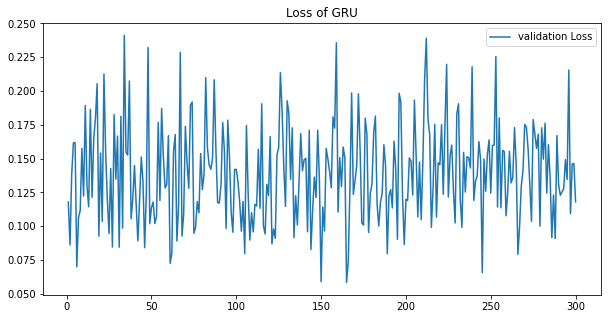

In [73]:
plt.figure(figsize=(10, 5))

plt.plot(range(1,len(val_losses_record) + 1),val_losses_record,label = "validation Loss")

plt.legend()
plt.title('Loss of GRU')
plt.show()

### Test the Model
#### Test Accuracy and Loss

In [77]:
model.load_state_dict(torch.load('good_model.pt'))
# use a list to record the test data loss
test_losses_list = []
# predict correct number
predict_correct_num = 0
h = model.init_hidden(batch_size)
predicted_y = []

model.eval()
for inputs_test, labels_test in test_loader:
    h = h.data
    inputs_test, labels_test = inputs_test.to(device), labels_test.to(device)
    output, h = model(inputs_test, h)
    test_loss = criterion(output.squeeze(), labels_test.float())
    test_losses_list.append(test_loss.item())
    # Rounds the output to 0/1
    prd = torch.round(output.squeeze())  
    for p in prd.tolist():
      predicted_y.append(int(p))
    correct_tensor = prd.eq(labels_test.float().view_as(prd))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    predict_correct_num += np.sum(correct)

print("Test loss: {:.3f}".format(np.mean(test_losses_list)))
test_acc = predict_correct_num/len(test_loader.dataset)
print("Test accuracy: {:.3f}%".format(test_acc*100))

Test loss: 0.137
Test accuracy: 94.917%


#### Confusion Matrix

In [78]:
report = classification_report(test_label, predicted_y)
print(report)

              precision    recall  f1-score   support

           0       0.95      0.94      0.95     70138
           1       0.94      0.95      0.95     69862

    accuracy                           0.95    140000
   macro avg       0.95      0.95      0.95    140000
weighted avg       0.95      0.95      0.95    140000



#### Heat Map

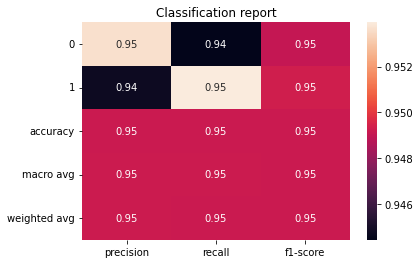

In [79]:
sns.heatmap(pd.DataFrame(classification_report(
         test_label, predicted_y, zero_division=0.0,output_dict=True)).iloc[:-1, :].T, annot=True)
plt.title('Classification report')
plt.show()

# Result of all 3 Models

| |  | precision | recall | f1-score | accuracy | weighted avg | loss 
|:----:|:------:|:-------:|:------------:|:-----------:|:-----------:|:-------------:|:---:
CNN|0|0.93|0.95|0.94|94.19%|0.94|0.158
 | |1| 0.95|0.93|0.94| |0.94
LSTM|0|0.95|0.94|0.94|94.150%|0.94|0.166
 | |1| 0.94|0.95|0.94| |0.94
GRU|0|0.94|0.95|0.95|94.917%|0.95|0.137
 | |1| 0.95|0.94|0.95| |0.95

# Discussion and Future Improvement

## Discussion of CNN
From the confusion matrix and classification report, it shows that the data set is balanced, so it can achieve high accuracy. On the other hand, if the data set is imbalanced, we may use much data to train the model.
In this task, I manually choose the parameters to find the best model, and in the future, I can use cross validation such as k-fold for hyper-parameters tuning, which will be more effective and more correct.
Furthermore, I can try to use keras and tensorflow to build the model, which is different from pytorch, but is also effective in machine learning and deep learning.  

## Discussion of LSTM
From the above classfication report and confusion matrix, it is obvious that micro and macro metircs are quite close, so this is a balance dataset.The original accuracy is 92.388%. But after all work have done, we changed the dropout from 0.5 to 0.2 to get a more optimal model. The accuracy of the new model is 94.15%, which is higher than 92.388%. This is probobaly beacuse the high dropout caused some information loss and LSTM failed to predict correctly. During the hyperparamter tuning, I changed the number of epochs and batch size manullay, the accuracy was always around 90% and it took 30 minutes to run each epoch. So there are still more I can improve in the future, I may use RandomSearchCV function to find much better parameters for LSTM model. 

## Discussion of GRU
As can be seen from the confusion matrix and classification report, the dataset is balanced, so high accuracy can be achieved.The accuracy rate of the model is close to 95%. In this model, the hidden layer dimension and dropout of the model, the number of GRU layers, and the learning rate are all manually adjusted by me, which does not mean that the current parameters are the GRU model. In the future, I will use the cross-validation method to adjust the optimal hyperparameters of the model to obtain the best performance of the model. When comparing with LSTM model, GRU model runs faster than LSTM model due to its simple parameters. But the model behaves pretty much the same. When both of them are optimal in terms of specific tasks and parameters, their performance is similar. But for this project, the accuracy of GRU model is slightly higher than that of LSTM. Therefore, we choose the GRU model as the final model.  

## Overall Discussion
We could see from the table of results, all of these 3 models reached test accuracy of 94%, which is really a nice performance. The GRU model performs slightly better. We tried several times  without changing parameters and hyperparameters, the GRU model always have the highest accuracy. Therefore, we finally decide to use the GRU model.  
In this project, we used three models for comparison, which can not only consolidate knowledge, but also compare which model is more suitable for this project.   
In future work, we can optimize the model by adjusting the parameters, such as adjusting the dropout value in the LSTM model, adding cross-validation to the CNN model to find the optimal parameters, and increasing the amount of data. After all, our project only uses half of the dataset.